<a href="https://colab.research.google.com/github/alxkzncoff/skillfactory_rds6_car_price_prediction_ml_dl/blob/main/car_price_ml_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEFINE

In [66]:
# DEFINE
DATA_PATH                   = '/content/drive/My Drive/skill_factory_car_price_prediction_ml_dl'
RANDOM_SEED                 = 42

# IMPORT

In [67]:
import re

# Analyse
import pandas as pd
pd.set_option('max_rows', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split

In [68]:
train = pd.read_csv(DATA_PATH+'/train.csv')
test = pd.read_csv(DATA_PATH+'/test.csv')

# FEATURES DESCRIBE

- **bodyType** - категориальный
- **brand** - категориальный
- **color** - категориальный
- **description** - текстовый
- **engineDisplacement** - числовой, представленный как текст
- **enginePower** - числовой, представленный как текст
- **fuelType** - категориальный
- **mileage** - числовой
- **modelDate** - числовой
- **model_info** - категориальный
- **name** - категориальный, желательно сократить размерность
- **numberOfDoors** - категориальный
- **price** - числовой, целевой
- **productionDate** - числовой
- **sell_id** - изображение (файл доступен по адресу, основанному на sell_id)
- **vehicleConfiguration** - не используется (комбинация других столбцов)
- **vehicleTransmission** - категориальный
- **Владельцы** - категориальный
- **Владение** - числовой, представленный как текст
- **ПТС** - категориальный
- **Привод** - категориальный
- **Руль** - категориальный

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [70]:
train.head(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


Построим *наивную* модель, чтобы понять в какую сторону двигаемся - к **улучшению** или к **ухудшению**.

Модель будет предсказывать среднюю цену авто по модели и году выпуска.


In [71]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [72]:
train_data, test_data = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [73]:
# Вместо iterrows() лучше всего использовать "Vectorization with Pandas series" и "Vectorization with NumPy arrays", так как
# они работают намного быстрее чем "iterrows()" и "apply()". В данном случае воспользуемся "iterrows()" так как датасет не такой большой.

predicts = []
for index, row in pd.DataFrame(test_data[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(train_data.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(test_data['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


По поводу итераций подробно расписано [здесь](https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas)

# EDA AND PREPROCCESING

In [74]:
# Анализ признаков
def column_info(column):

  if column.dtype == 'O':
    print(column.describe())
    print('-----------------------------')
    print(column.value_counts())

  else:
    print(column.describe())
    plt.figure(figsize=(20,7))
    sns.histplot(train, x=column)

## bodyType

In [75]:
column_info(train.bodyType)

count      6682
unique       17
top       седан
freq       2843
Name: bodyType, dtype: object
-----------------------------
седан                   2843
внедорожник 5 дв.       2315
купе                     427
хэтчбек 5 дв.            296
лифтбек                  245
универсал 5 дв.          153
минивэн                  146
купе-хардтоп              91
родстер                   60
кабриолет                 44
хэтчбек 3 дв.             41
компактвэн                 8
лимузин                    5
внедорожник 3 дв.          3
внедорожник открытый       2
пикап двойная кабина       2
седан 2 дв.                1
Name: bodyType, dtype: int64


In [76]:
train.bodyType = train.bodyType.apply(lambda x: x.split()[0])

## brand

In [77]:
column_info(train.brand)

count     6682
unique       3
top        BMW
freq      2805
Name: brand, dtype: object
-----------------------------
BMW         2805
MERCEDES    2294
AUDI        1583
Name: brand, dtype: int64


## color

In [78]:
column_info(train.color)

count       6682
unique        16
top       чёрный
freq        2805
Name: color, dtype: object
-----------------------------
чёрный         2805
белый          1263
серый           733
синий           685
серебристый     341
коричневый      307
красный         203
бежевый          76
голубой          72
зелёный          70
фиолетовый       37
пурпурный        30
оранжевый        22
золотистый       21
жёлтый           16
розовый           1
Name: color, dtype: int64


## engineDisplacement

In [79]:
column_info(train.engineDisplacement)

count        6682
unique         48
top       2.0 LTR
freq         1929
Name: engineDisplacement, dtype: object
-----------------------------
2.0 LTR          1929
3.0 LTR          1862
1.8 LTR           329
1.6 LTR           327
4.4 LTR           260
5.5 LTR           227
3.5 LTR           208
2.5 LTR           203
2.1 LTR           181
4.0 LTR           121
4.7 LTR           109
2.8 LTR            89
1.4 LTR            82
4.2 LTR            80
1.5 LTR            61
5.0 LTR            60
3.2 LTR            49
2.2 LTR            44
2.9 LTR            43
4.8 LTR            41
3.1 LTR            39
2.4 LTR            38
6.2 LTR            31
6.0 LTR            30
1.3 LTR            30
5.4 LTR            27
1.2 LTR            26
2.7 LTR            22
4.1 LTR            19
3.6 LTR            18
1.7 LTR            11
3.7 LTR            11
5.2 LTR            10
5.9 LTR            10
2.6 LTR             7
2.3 LTR             5
undefined LTR       5
0.7 LTR             5
4.6 LTR             5


In [80]:
train[train.engineDisplacement=='undefined LTR']

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
2296,хэтчбек,BMW,чёрный,"Автомобиль в наличии Москве , с ПТС , производ...",undefined LTR,184 N12,электро,9000,2017,I3,S Electro AT (136 кВт),5,2719000.0,2019,1100083262,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
3725,хэтчбек,BMW,чёрный,"BMW i3 Электромобиль с бензиновым генератором,...",undefined LTR,170 N12,электро,39500,2017,I3,Electro AT (126 кВт),5,2299711.0,2017,1098041130,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,2 года и 11 месяцев,Оригинал,задний,Левый
3726,хэтчбек,BMW,голубой,Прибыло из Америки в августе 20 года. Полная и...,undefined LTR,170 N12,электро,28800,2017,I3,Electro AT (126 кВт),5,2170000.0,2017,1100097316,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
5862,хэтчбек,BMW,белый,В наличии! Автомобиль куплен в США! Комплектац...,undefined LTR,170 N12,электро,35810,2013,I3,Electro AT (126 кВт),5,1690000.0,2016,1100153696,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
6283,хэтчбек,BMW,чёрный,Авто в идеальном состоянии\nЕсть REX (range ex...,undefined LTR,170 N12,электро,60000,2013,I3,Electro AT (126 кВт),5,1790000.0,2015,1097395090,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый


По данным видно, что это электрокары. Гугл говорит, что у модели i3 объем двигателя составляет **0.6**.

In [81]:
train.engineDisplacement[train.engineDisplacement=='undefined LTR'] = '0.6 LTR'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
train.engineDisplacement = train.engineDisplacement.apply(lambda x: x.split()[0])
train.engineDisplacement = train.engineDisplacement.astype('float64')

## enginePower

In [83]:
column_info(train.enginePower)

count        6682
unique        146
top       184 N12
freq          602
Name: enginePower, dtype: object
-----------------------------
184 N12    602
249 N12    531
190 N12    343
306 N12    282
245 N12    274
211 N12    244
150 N12    218
170 N12    215
218 N12    189
156 N12    177
272 N12    163
136 N12    159
231 N12    144
204 N12    138
258 N12    131
333 N12    124
180 N12    115
177 N12    109
122 N12     81
585 N12     79
367 N12     78
224 N12     76
407 N12     74
388 N12     72
225 N12     71
160 N12     67
450 N12     62
192 N12     62
340 N12     62
235 N12     62
320 N12     58
313 N12     54
435 N12     50
163 N12     49
115 N12     48
455 N12     42
265 N12     40
290 N12     39
310 N12     39
555 N12     39
381 N12     39
300 N12     38
197 N12     35
575 N12     34
286 N12     32
350 N12     31
220 N12     28
612 N12     28
557 N12     26
571 N12     24
105 N12     24
255 N12     24
140 N12     23
230 N12     23
500 N12     23
238 N12     23
125 N12     22
296 N12   

In [84]:
train.enginePower = train.enginePower.apply(lambda x: x.split()[0])
train.enginePower = train.enginePower.astype('float64')

## fuelType

In [85]:
column_info(train.fuelType)

count       6682
unique         4
top       бензин
freq        4804
Name: fuelType, dtype: object
-----------------------------
бензин     4804
дизель     1861
гибрид       12
электро       5
Name: fuelType, dtype: int64


## mileage

count      6682.000000
mean     120522.610895
std       81454.448294
min           1.000000
25%       59181.250000
50%      111000.000000
75%      168000.000000
max      999999.000000
Name: mileage, dtype: float64


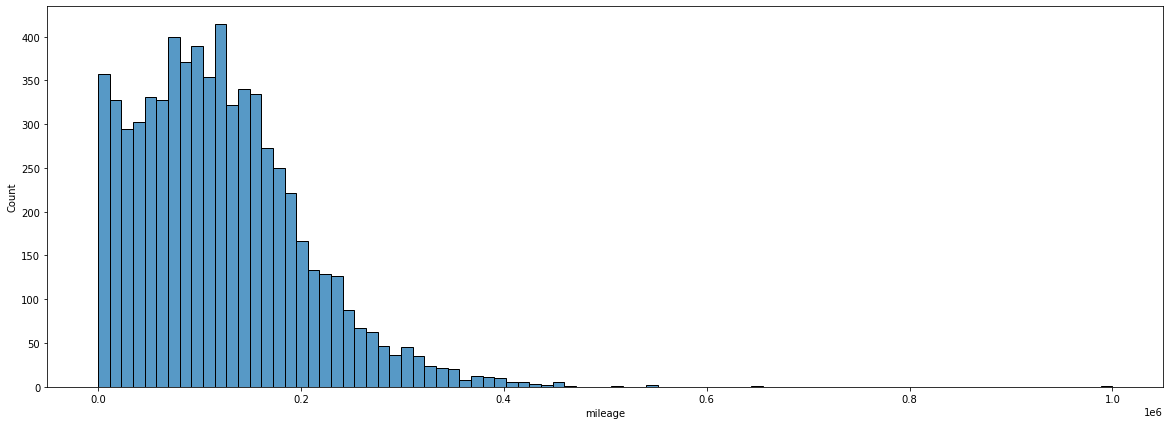

In [86]:
column_info(train.mileage)

## modelDate

count    6682.000000
mean     2010.135588
std         5.370973
min      1975.000000
25%      2007.000000
50%      2011.000000
75%      2014.000000
max      2019.000000
Name: modelDate, dtype: float64


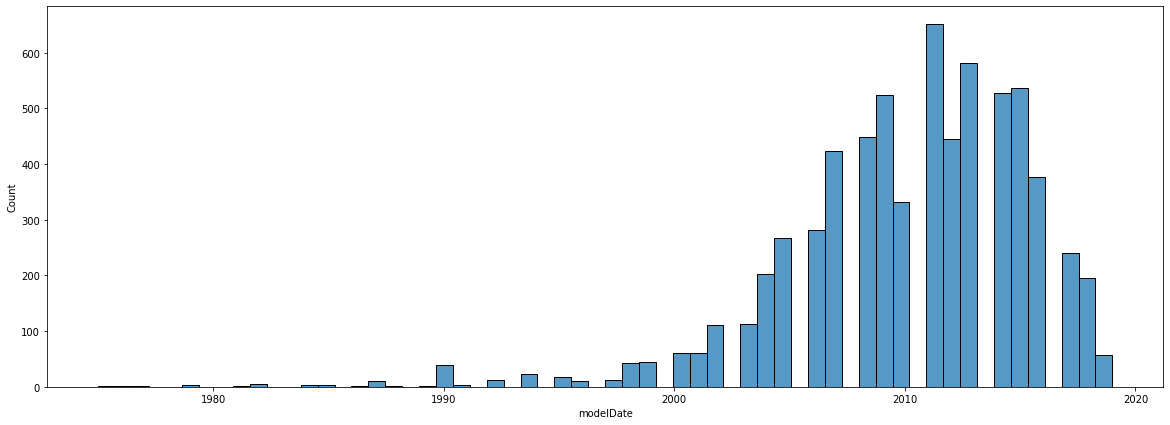

In [87]:
column_info(train.modelDate)

## model_info

In [88]:
column_info(train.model_info)

count     6682
unique     118
top        5ER
freq       611
Name: model_info, dtype: object
-----------------------------
5ER                     611
3ER                     466
E_KLASSE                410
X5                      397
A6                      358
A4                      237
7ER                     229
C_KLASSE                222
X3                      216
X6                      215
S_KLASSE                214
Q7                      170
A5                      150
Q5                      148
1ER                     141
M_KLASSE                135
X1                      122
GL_KLASSE               115
A8                      106
A3                      105
G_KLASSE                 91
6ER                      76
CLS_KLASSE               74
A7                       70
GLK_KLASSE               69
Q3                       66
GLC_KLASSE               61
G_KLASSE_AMG             57
S_KLASSE_AMG             57
X4                       56
V_KLASSE                 55
A_KLASSE  

## name

In [89]:
column_info(train.name)

count                      6682
unique                      900
top       200 2.0 AT (184 л.с.)
freq                        121
Name: name, dtype: object
-----------------------------
200 2.0 AT (184 л.с.)                                121
35i 3.0 AT (306 л.с.) 4WD                            116
2.0 AMT (211 л.с.) 4WD                               113
30d 3.0d AT (249 л.с.) 4WD                            87
400 3.0 AT (333 л.с.) 4WD                             76
2.0 AMT (249 л.с.) 4WD                                65
520i 2.0 AT (184 л.с.)                                65
350 d 3.0d AT (249 л.с.) 4WD                          64
320i xDrive 2.0 AT (184 л.с.) 4WD                     64
200 1.8 AT (184 л.с.)                                 61
2.0 CVT (180 л.с.)                                    61
1.8 CVT (160 л.с.)                                    60
350 3.5 AT (272 л.с.) 4WD                             56
200 2.0 AT (184 л.с.) 4WD                             49
520d 2.0d AT (190 

In [90]:
train.name[train.brand=='BMW'].value_counts()

35i 3.0 AT (306 л.с.) 4WD                 116
30d 3.0d AT (249 л.с.) 4WD                 87
520i 2.0 AT (184 л.с.)                     65
320i xDrive 2.0 AT (184 л.с.) 4WD          64
520d 2.0d AT (190 л.с.)                    49
3.0i 3.0 AT (231 л.с.) 4WD                 48
30d 3.0d AT (245 л.с.) 4WD                 46
528i xDrive 2.0 AT (245 л.с.) 4WD          42
116i 1.6 AT (115 л.с.)                     42
520d xDrive 2.0d AT (190 л.с.) 4WD         41
530d xDrive 3.0d AT (258 л.с.) 4WD         41
4.4 AT (555 л.с.) 4WD                      39
320i 2.0 AT (156 л.с.)                     39
320i 2.0 AT (184 л.с.)                     38
20d xDrive 2.0d AT (190 л.с.) 4WD          36
40d 3.0d AT (313 л.с.) 4WD                 35
325i 2.5 AT (218 л.с.)                     34
318i 2.0 AT (136 л.с.)                     34
4.4 AT (575 л.с.) 4WD                      33
18i 2.0 AT (150 л.с.)                      33
40d 3.0d AT (306 л.с.) 4WD                 32
20i 2.0 AT (184 л.с.) 4WD         

In [91]:
BMW = train[train.brand=='BMW']
BMW.reset_index(drop=True, inplace=True)

нужно воспользоваться регулярными выражениями

In [27]:
# BMW.name = BMW.name.apply(lambda x: x.split())

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [105]:
BMW.name = BMW.name.apply(lambda x: ' '.join(x.split()[0:2]) if len(x.split()[1])>3 else x.split()[0])

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [107]:
BMW.name.value_counts()

30d 3.0d               172
35i                    117
320i                   105
4.4                     90
520i                    89
520d 2.0d               77
116i                    74
530d xDrive             74
20d 2.0d                72
40d 3.0d                67
20d xDrive              65
320i xDrive             64
318i                    58
525i                    54
3.0i                    49
320d xDrive             46
528i xDrive             42
520d xDrive             41
325i                    41
30i                     41
20i xDrive              39
118i                    38
50i                     35
M50d 3.0d               33
18i                     33
20i                     32
320d 2.0d               32
316i                    29
750Li xDrive            29
28i xDrive              28
523i                    26
3.0d 3.0d               25
30d xDrive              24
25d 3.0d                24
325xi                   24
530i                    22
25i                     22
5

In [104]:
a

'740Li xDrive'